In [3]:
import os
import sys
import torch
import torchvision
import torchvision.models as pt_models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

sys.path.insert(0, "..")
from my_models import *
from methods import *
from qheader import *
from q1_theory import *

sys.path.insert(0, "additive_smoothing")
from additive_wrappers import *

PID: 1540316


In [4]:
configs = make_default_configs() # qheader configs
imagenet_dataset = configs["imagenet_dataset"]
exbits_list = load_exbits_list("vit16", "shap", 0.25, configs["exbits_dir"], q=64, patch_size=28)
exbits_list = exbits_list

mus_vit16_1000_saveto = "additive_smoothing/mus_vit16_lam1000.csv"
mus_vit16_0500_saveto = "additive_smoothing/mus_vit16_lam0500.csv"
mus_vit16_0250_saveto = "additive_smoothing/mus_vit16_lam0250.csv"
mus_vit16_0125_saveto = "additive_smoothing/mus_vit16_lam0125.csv"

add_vit16_1000_saveto = "additive_smoothing/add_vit16_lam1000.csv"
add_vit16_0500_saveto = "additive_smoothing/add_vit16_lam0500.csv"
add_vit16_0250_saveto = "additive_smoothing/add_vit16_lam0250.csv"
add_vit16_0125_saveto = "additive_smoothing/add_vit16_lam0125.csv"

vit16_emp_saveto = "additive_smoothing/emp_r1_check.csv"

vit16_fig_saveto = "additive_comparison_vit16.png"

In [5]:
q, psz = 64, 28
M = q
mus_vit16_1000 = load_model("vit16", configs["models_dir"], patch_size=psz, lambd=1.0, q=q)
add_vit16_1000 = AdditiveImageNet(mus_vit16_1000.base_model, patch_size=psz, lambd=1.0, num_samples=M)

mus_vit16_0500 = load_model("vit16", configs["models_dir"], patch_size=psz, lambd=0.50, q=q)
add_vit16_0500 = AdditiveImageNet(mus_vit16_0500.base_model, patch_size=psz, lambd=0.5, num_samples=M)

mus_vit16_0250 = load_model("vit16", configs["models_dir"], patch_size=psz, lambd=0.25, q=q)
add_vit16_0250 = AdditiveImageNet(mus_vit16_0250.base_model, patch_size=psz, lambd=0.25, num_samples=M)

mus_vit16_0125 = load_model("vit16", configs["models_dir"], patch_size=psz, lambd=0.125, q=q)
add_vit16_0125 = AdditiveImageNet(mus_vit16_0125.base_model, patch_size=psz, lambd=0.125, num_samples=M)

mus_vit16_1000.eval(), mus_vit16_0500.eval(), mus_vit16_0250.eval(), mus_vit16_0125.eval()
add_vit16_1000.eval(), add_vit16_0500.eval(), add_vit16_0250.eval(), add_vit16_0125.eval()
;

loading: vit16_durt_psz28_ft__1.0000_0.5000__epoch5.pt
loading: vit16_durt_psz28_ft__0.5000_0.2500__epoch5.pt
loading: vit16_durt_psz28_ft__0.2500_0.1250__epoch5.pt
loading: vit16_durt_psz28_ft__0.1250_0.0625__epoch5.pt


''

In [ ]:
## Q1 Theory

In [ ]:
mus_vit16_1000_df = q1t_test_radii(mus_vit16_1000, exbits_list, imagenet_dataset, \
                                   csv_saveto=mus_vit16_1000_saveto)
mus_vit16_0500_df = q1t_test_radii(mus_vit16_0500, exbits_list, imagenet_dataset, \
                                   csv_saveto=mus_vit16_0500_saveto)
mus_vit16_0250_df = q1t_test_radii(mus_vit16_0250, exbits_list, imagenet_dataset, \
                                   csv_saveto=mus_vit16_0250_saveto)
mus_vit16_0125_df = q1t_test_radii(mus_vit16_0125, exbits_list, imagenet_dataset, \
                                   csv_saveto=mus_vit16_0125_saveto)

In [ ]:
add_vit16_1000_df = q1t_test_radii(add_vit16_1000, exbits_list, imagenet_dataset, \
                                   csv_saveto=add_vit16_1000_saveto)
add_vit16_0500_df = q1t_test_radii(add_vit16_0500, exbits_list, imagenet_dataset, \
                                   csv_saveto=add_vit16_0500_saveto)
add_vit16_0250_df = q1t_test_radii(add_vit16_0250, exbits_list, imagenet_dataset, \
                                   csv_saveto=add_vit16_0250_saveto)
add_vit16_0125_df = q1t_test_radii(add_vit16_0125, exbits_list, imagenet_dataset, \
                                   csv_saveto=add_vit16_0125_saveto)

In [ ]:
## Loading shortcuts

In [6]:
mus_vit16_1000_df = pd.read_csv(mus_vit16_1000_saveto)
mus_vit16_0500_df = pd.read_csv(mus_vit16_0500_saveto)
mus_vit16_0250_df = pd.read_csv(mus_vit16_0250_saveto)
mus_vit16_0125_df = pd.read_csv(mus_vit16_0125_saveto)

add_vit16_1000_df = pd.read_csv(add_vit16_1000_saveto)
add_vit16_0500_df = pd.read_csv(add_vit16_0500_saveto)
add_vit16_0250_df = pd.read_csv(add_vit16_0250_saveto)
add_vit16_0125_df = pd.read_csv(add_vit16_0125_saveto)

In [7]:
## Plotting

In [8]:
def q1t_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    ones_gaps = (df["ones_mu_gap"] if use_mu else df["ones_gap"]).to_numpy()
    exbs_gaps = (df["exbs_mu_gap"] if use_mu else df["exbs_gap"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    todo_gaps = exbs_gaps if prop == "inc" else ones_gaps
    
    N = len(df)
    lambd = df["lambd"][0]
    cert_rs = todo_gaps / (2 * lambd)
    
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    
    if consistent:
        hit_bits = ones_labels == exbs_labels
        drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(cert_rs >= r).sum() / N for r in rs])

    return drops


In [9]:
rs = np.linspace(0.0, 4.1, 500)

mus_1000_drops_wc = q1t_drops(mus_vit16_1000_df, rs, prop="inc", consistent=True)
mus_0500_drops_wc = q1t_drops(mus_vit16_0500_df, rs, prop="inc", consistent=True)
mus_0250_drops_wc = q1t_drops(mus_vit16_0250_df, rs, prop="inc", consistent=True)
mus_0125_drops_wc = q1t_drops(mus_vit16_0125_df, rs, prop="inc", consistent=True)

add_1000_drops_wc = q1t_drops(add_vit16_1000_df, rs, prop="inc", consistent=True)
add_0500_drops_wc = q1t_drops(add_vit16_0500_df, rs, prop="inc", consistent=True)
add_0250_drops_wc = q1t_drops(add_vit16_0250_df, rs, prop="inc", consistent=True)
add_0125_drops_wc = q1t_drops(add_vit16_0125_df, rs, prop="inc", consistent=True)

mus_1000_drops_nc = q1t_drops(mus_vit16_1000_df, rs, prop="inc", consistent=False)
mus_0500_drops_nc = q1t_drops(mus_vit16_0500_df, rs, prop="inc", consistent=False)
mus_0250_drops_nc = q1t_drops(mus_vit16_0250_df, rs, prop="inc", consistent=False)
mus_0125_drops_nc = q1t_drops(mus_vit16_0125_df, rs, prop="inc", consistent=False)

add_1000_drops_nc = q1t_drops(add_vit16_1000_df, rs, prop="inc", consistent=False)
add_0500_drops_nc = q1t_drops(add_vit16_0500_df, rs, prop="inc", consistent=False)
add_0250_drops_nc = q1t_drops(add_vit16_0250_df, rs, prop="inc", consistent=False)
add_0125_drops_nc = q1t_drops(add_vit16_0125_df, rs, prop="inc", consistent=False)


<Figure size 640x480 with 0 Axes>

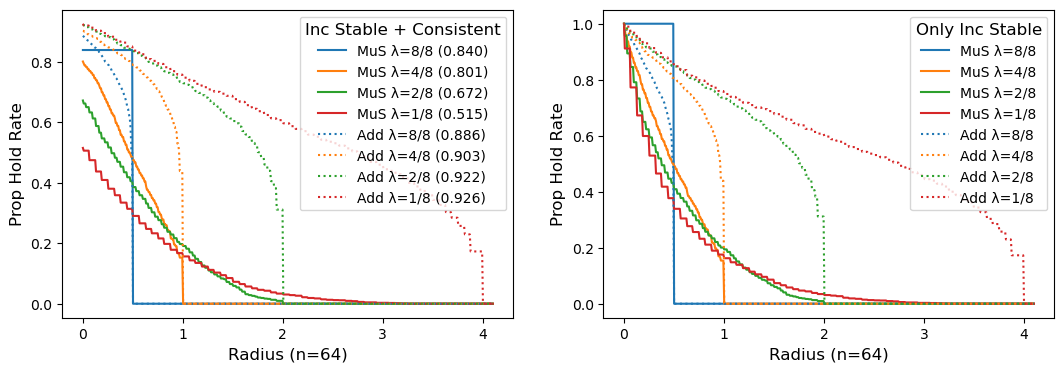

In [10]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.0))

ax[0].plot(rs, mus_1000_drops_wc, color="C0", linestyle="solid", label=f"MuS λ=8/8 ({mus_1000_drops_wc[0]:.3f})")
ax[0].plot(rs, mus_0500_drops_wc, color="C1", linestyle="solid", label=f"MuS λ=4/8 ({mus_0500_drops_wc[0]:.3f})")
ax[0].plot(rs, mus_0250_drops_wc, color="C2", linestyle="solid", label=f"MuS λ=2/8 ({mus_0250_drops_wc[0]:.3f})")
ax[0].plot(rs, mus_0125_drops_wc, color="C3", linestyle="solid", label=f"MuS λ=1/8 ({mus_0125_drops_wc[0]:.3f})")
ax[0].plot(rs, add_1000_drops_wc, color="C0", linestyle="dotted", label=f"Add λ=8/8 ({add_1000_drops_wc[0]:.3f})")
ax[0].plot(rs, add_0500_drops_wc, color="C1", linestyle="dotted", label=f"Add λ=4/8 ({add_0500_drops_wc[0]:.3f})")
ax[0].plot(rs, add_0250_drops_wc, color="C2", linestyle="dotted", label=f"Add λ=2/8 ({add_0250_drops_wc[0]:.3f})")
ax[0].plot(rs, add_0125_drops_wc, color="C3", linestyle="dotted", label=f"Add λ=1/8 ({add_0125_drops_wc[0]:.3f})")
ax[0].legend(loc="upper right", title="Inc Stable + Consistent", title_fontsize=12)
ax[0].set_ylabel("Prop Hold Rate", fontsize=12)
ax[0].set_xlabel("Radius (n=64)", fontsize=12)

ax[1].plot(rs, mus_1000_drops_nc, color="C0", linestyle="solid", label=f"MuS λ=8/8")
ax[1].plot(rs, mus_0500_drops_nc, color="C1", linestyle="solid", label=f"MuS λ=4/8")
ax[1].plot(rs, mus_0250_drops_nc, color="C2", linestyle="solid", label=f"MuS λ=2/8")
ax[1].plot(rs, mus_0125_drops_nc, color="C3", linestyle="solid", label=f"MuS λ=1/8")
ax[1].plot(rs, add_1000_drops_nc, color="C0", linestyle="dotted", label=f"Add λ=8/8")
ax[1].plot(rs, add_0500_drops_nc, color="C1", linestyle="dotted", label=f"Add λ=4/8")
ax[1].plot(rs, add_0250_drops_nc, color="C2", linestyle="dotted", label=f"Add λ=2/8")
ax[1].plot(rs, add_0125_drops_nc, color="C3", linestyle="dotted", label=f"Add λ=1/8")
ax[1].legend(loc="upper right", title="Only Inc Stable", title_fontsize=12)
ax[1].set_ylabel("Prop Hold Rate", fontsize=12)
ax[1].set_xlabel("Radius (n=64)", fontsize=12)

plt.savefig(vit16_fig_saveto, bbox_inches="tight", transparent=True)

In [22]:
torch.cuda.empty_cache()

mus_vit16_1000.q = 16
mus_vit16_0500.q = 16
mus_vit16_0250.q = 16
mus_vit16_0125.q = 16

add_vit16_1000.num_samples = 16
add_vit16_0500.num_samples = 16
add_vit16_0250.num_samples = 16
add_vit16_0125.num_samples = 16

mus_vit16_1000.cuda(), mus_vit16_0500.cuda(), mus_vit16_0250.cuda(), mus_vit16_0125.cuda()
add_vit16_1000.cuda(), add_vit16_0500.cuda(), add_vit16_0250.cuda(), add_vit16_0125.cuda()
;

''

In [23]:
spsz = 4

df = pd.DataFrame(columns=[
    "mus_vit16_1000", "mus_vit16_0500", "mus_vit16_0250", "mus_vit16_0125",
    "add_vit16_1000", "add_vit16_0500", "add_vit16_0250", "add_vit16_0125",
])
pbar = tqdm(range(250))
for i in pbar:
    alpha = exbits_list[i]
    x, true_label = imagenet_dataset[i]
    x, alpha = x.cuda(), alpha.cuda()
    pertb_bits = (alpha == 0).int()

    this_mus_1000_r1_ok = check_r1_robust(mus_vit16_1000, x, alpha, pertb_bits, split_size=spsz)[0]
    this_mus_0500_r1_ok = check_r1_robust(mus_vit16_0500, x, alpha, pertb_bits, split_size=spsz)[0]
    this_mus_0250_r1_ok = check_r1_robust(mus_vit16_0250, x, alpha, pertb_bits, split_size=spsz)[0]
    this_mus_0125_r1_ok = check_r1_robust(mus_vit16_0125, x, alpha, pertb_bits, split_size=spsz)[0]

    this_add_1000_r1_ok = check_r1_robust(add_vit16_1000, x, alpha, pertb_bits, split_size=spsz)[0]
    this_add_0500_r1_ok = check_r1_robust(add_vit16_0500, x, alpha, pertb_bits, split_size=spsz)[0]
    this_add_0250_r1_ok = check_r1_robust(add_vit16_0250, x, alpha, pertb_bits, split_size=spsz)[0]
    this_add_0125_r1_ok = check_r1_robust(add_vit16_0125, x, alpha, pertb_bits, split_size=spsz)[0]

    this_df = pd.DataFrame({
        "mus_vit16_1000" : this_mus_1000_r1_ok,
        "mus_vit16_0500" : this_mus_0500_r1_ok,
        "mus_vit16_0250" : this_mus_0250_r1_ok,
        "mus_vit16_0125" : this_mus_0125_r1_ok,
        
        "add_vit16_1000" : this_add_1000_r1_ok,
        "add_vit16_0500" : this_add_0500_r1_ok,
        "add_vit16_0250" : this_add_0250_r1_ok,
        "add_vit16_0125" : this_add_0125_r1_ok,
        }, index = [i])

    df = pd.concat([df, this_df])
    df.to_csv(vit16_emp_saveto)

    # do the description string
    desc_str = f"mus ("
    desc_str += f"{np.array(df['mus_vit16_1000']).mean():.3f}, "
    desc_str += f"{np.array(df['mus_vit16_0500']).mean():.3f}, "
    desc_str += f"{np.array(df['mus_vit16_0250']).mean():.3f}, "
    desc_str += f"{np.array(df['mus_vit16_0125']).mean():.3f}), "

    desc_str += "add ("
    desc_str += f"{np.array(df['add_vit16_1000']).mean():.3f}, "
    desc_str += f"{np.array(df['add_vit16_0500']).mean():.3f}, "
    desc_str += f"{np.array(df['add_vit16_0250']).mean():.3f}, "
    desc_str += f"{np.array(df['add_vit16_0125']).mean():.3f}), "
    
    pbar.set_description(desc_str)


mus (0.716, 0.660, 0.512, 0.364), add (0.816, 0.848, 0.864, 0.824), : 100%|██████████| 250/250 [43:59<00:00, 10.56s/it]


In [24]:
desc_str = f"mus ("
desc_str += f"{np.array(df['mus_vit16_1000']).mean():.3f}, "
desc_str += f"{np.array(df['mus_vit16_0500']).mean():.3f}, "
desc_str += f"{np.array(df['mus_vit16_0250']).mean():.3f}, "
desc_str += f"{np.array(df['mus_vit16_0125']).mean():.3f}), "

desc_str += "add ("
desc_str += f"{np.array(df['add_vit16_1000']).mean():.3f}, "
desc_str += f"{np.array(df['add_vit16_0500']).mean():.3f}, "
desc_str += f"{np.array(df['add_vit16_0250']).mean():.3f}, "
desc_str += f"{np.array(df['add_vit16_0125']).mean():.3f}), "

print(desc_str)

mus (0.716, 0.660, 0.512, 0.364), add (0.816, 0.848, 0.864, 0.824), 
